<a href="https://colab.research.google.com/gist/soukainaRhazzafe/9f716c3dc8593b6135ae3de3144af0aa/titanicsurvivalscala.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configuration spark:

In [ ]:
%%init_spark
launcher.num_executors = 4
launcher.executor_cores = 2
launcher.driver_memory = '4g'

# Ouvrir une session spark:

In [ ]:
!jt -r

Reset css and font defaults in:
C:\Users\PC\.jupyter\custom &
C:\Users\PC\AppData\Roaming\jupyter\nbextensions



In [ ]:
import org.apache.spark.sql.SparkSession
val spark = SparkSession.builder().appName("Spark").config("app","tdrt").getOrCreate()
val sc= spark.sparkContext

Intitializing Scala interpreter ...

Spark Web UI available at http://soukaina:4040
SparkContext available as 'sc' (version = 3.1.3, master = local[*], app id = local-1653486311142)
SparkSession available as 'spark'


import org.apache.spark.sql.SparkSession
spark: org.apache.spark.sql.SparkSession = org.apache.spark.sql.SparkSession@7df407ab
sc: org.apache.spark.SparkContext = org.apache.spark.SparkContext@bc7688b


# Importation des librairies:

In [ ]:
import org.apache.spark.ml.feature.{OneHotEncoder, StringIndexer}
import org.apache.spark.ml._
import org.apache.spark.ml.feature._
import org.apache.spark.ml.classification.RandomForestClassifier
import org.apache.spark.sql.functions._
import org.apache.spark.sql.SaveMode
import org.apache.spark.sql.DataFrame
import org.apache.spark.sql.types.IntegerType
import org.apache.spark.ml.tuning.ParamGridBuilder
import org.apache.spark.ml.param.ParamMap
import org.apache.spark.ml.tuning.CrossValidator
import org.apache.spark.ml.evaluation.BinaryClassificationEvaluator
import org.apache.spark.mllib.evaluation.MulticlassMetrics

import org.apache.spark.ml.feature.{OneHotEncoder, StringIndexer}
import org.apache.spark.ml._
import org.apache.spark.ml.feature._
import org.apache.spark.ml.classification.RandomForestClassifier
import org.apache.spark.sql.functions._
import org.apache.spark.sql.SaveMode
import org.apache.spark.sql.DataFrame
import org.apache.spark.sql.types.IntegerType
import org.apache.spark.ml.tuning.ParamGridBuilder
import org.apache.spark.ml.param.ParamMap
import org.apache.spark.ml.tuning.CrossValidator
import org.apache.spark.ml.evaluation.BinaryClassificationEvaluator
import org.apache.spark.mllib.evaluation.MulticlassMetrics


# Chargement des donnees:

In [ ]:
val titanic = spark.read.option("header", "true").option("inferSchema", "true").csv("titanicDataset1.csv")

titanic: org.apache.spark.sql.DataFrame = [PassengerId: int, Survived: int ... 10 more fields]


# Le dataset:

In [ ]:
titanic.show()

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| null|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| null|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| null|       S|
|          6|       0|     3|    Moran, Mr. James|  male|null|    0|    0|      

# Description des colonnes:

1. PassengerID:
2. Survived: whether the passenger has survived the ship sinking (1) or not (0).
3. Pclass - Passenger's Ccass (1 = 1st; 2 = 2nd; 3 = 3rd)
4. Name - Passenger's name
5. Sex - Passenger's sex
6. Age - Passenger's age
7. Sibsp - Number of Siblings/Spouses Aboard
8. Parch - Number of Parents/Children Aboard
9. Ticket - Ticket Number
10. Fare - Passenger's ticket's fare
11. Cabin - Cabin
12. Embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

# Nombre de ligne:

In [ ]:
titanic.count()

res1: Long = 891


# Les informations sur les donnees:

In [ ]:
titanic.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



# Les types des donnees sont compatibles avec les valeurs des colonnes.


# Suppression des colonnes non pertinantes:

In [ ]:
val Titanic= titanic.drop("PassengerId","Name","Ticket")

Titanic: org.apache.spark.sql.DataFrame = [Survived: int, Pclass: int ... 7 more fields]


In [ ]:
Titanic.show()

+--------+------+------+----+-----+-----+-------+-----+--------+
|Survived|Pclass|   Sex| Age|SibSp|Parch|   Fare|Cabin|Embarked|
+--------+------+------+----+-----+-----+-------+-----+--------+
|       0|     3|  male|22.0|    1|    0|   7.25| null|       S|
|       1|     1|female|38.0|    1|    0|71.2833|  C85|       C|
|       1|     3|female|26.0|    0|    0|  7.925| null|       S|
|       1|     1|female|35.0|    1|    0|   53.1| C123|       S|
|       0|     3|  male|35.0|    0|    0|   8.05| null|       S|
|       0|     3|  male|null|    0|    0| 8.4583| null|       Q|
|       0|     1|  male|54.0|    0|    0|51.8625|  E46|       S|
|       0|     3|  male| 2.0|    3|    1| 21.075| null|       S|
|       1|     3|female|27.0|    0|    2|11.1333| null|       S|
|       1|     2|female|14.0|    1|    0|30.0708| null|       C|
|       1|     3|female| 4.0|    1|    1|   16.7|   G6|       S|
|       1|     1|female|58.0|    0|    0|  26.55| C103|       S|
|       0|     3|  male|2

# Suppression des lignes dupliquees :

In [ ]:
val df =  Titanic.dropDuplicates()
println("Distinct count: "+df.count())
df.show()

Distinct count: 784
+--------+------+------+----+-----+-----+-------+-------+--------+
|Survived|Pclass|   Sex| Age|SibSp|Parch|   Fare|  Cabin|Embarked|
+--------+------+------+----+-----+-----+-------+-------+--------+
|       1|     2|  male| 1.0|    2|    1|   39.0|     F4|       S|
|       0|     3|  male|22.0|    0|    0| 7.8958|   null|       S|
|       1|     3|female|22.0|    0|    0|   7.25|   null|       S|
|       0|     3|  male|22.0|    0|    0| 7.7958|   null|       S|
|       1|     1|female|44.0|    0|    1|57.9792|    B18|       C|
|       1|     1|  male|50.0|    2|    0| 133.65|   null|       S|
|       1|     1|  male|0.92|    1|    2| 151.55|C22 C26|       S|
|       0|     2|  male|43.0|    1|    1|  26.25|   null|       S|
|       0|     3|  male|24.0|    0|    0| 7.7958|   null|       S|
|       0|     1|  male|50.0|    1|    0|106.425|    C86|       C|
|       0|     3|  male|30.5|    0|    0|   8.05|   null|       S|
|       1|     2|female|27.0|    1|    0|1

df: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [Survived: int, Pclass: int ... 7 more fields]


In [ ]:
val df= Titanic.distinct()
println("Distinct count: "+df.count())
df.show()

Distinct count: 784
+--------+------+------+----+-----+-----+-------+-------+--------+
|Survived|Pclass|   Sex| Age|SibSp|Parch|   Fare|  Cabin|Embarked|
+--------+------+------+----+-----+-----+-------+-------+--------+
|       1|     2|  male| 1.0|    2|    1|   39.0|     F4|       S|
|       0|     3|  male|22.0|    0|    0| 7.8958|   null|       S|
|       1|     3|female|22.0|    0|    0|   7.25|   null|       S|
|       0|     3|  male|22.0|    0|    0| 7.7958|   null|       S|
|       1|     1|female|44.0|    0|    1|57.9792|    B18|       C|
|       1|     1|  male|50.0|    2|    0| 133.65|   null|       S|
|       1|     1|  male|0.92|    1|    2| 151.55|C22 C26|       S|
|       0|     2|  male|43.0|    1|    1|  26.25|   null|       S|
|       0|     3|  male|24.0|    0|    0| 7.7958|   null|       S|
|       0|     1|  male|50.0|    1|    0|106.425|    C86|       C|
|       0|     3|  male|30.5|    0|    0|   8.05|   null|       S|
|       1|     2|female|27.0|    1|    0|1

df: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [Survived: int, Pclass: int ... 7 more fields]


# Traitement des valeurs manquantes:

In [ ]:
println("Null values Survived : "+df.filter(df("Survived").isNull).count())
println("Null values PClass : "+df.filter(df("PClass").isNull).count())
println("Null values Age : "+df.filter(df("Age").isNull).count())
println("Null values Sex : "+df.filter(df("Sex").isNull).count())
println("Null values Sibsp : "+df.filter(df("Sibsp").isNull).count())
println("Null values Parch : "+df.filter(df("Parch").isNull).count())
println("Null values Fare : "+df.filter(df("Fare").isNull).count())
println("Null values Cabin : "+df.filter(df("Cabin").isNull).count())
println("Null values Embarked : "+df.filter(df("Embarked").isNull).count())

Null values Survived : 0
Null values PClass : 0
Null values Age : 106
Null values Sex : 0
Null values Sibsp : 0
Null values Parch : 0
Null values Fare : 0
Null values Cabin : 581
Null values Embarked : 2


# Beaucoup de valeurs manquantes de la colonne "Cabin" => il faut qu'on la supprime , les valeurs manquantes de la colonne "Age" peux etre rempli et les lignes dans la valeur de la colonne "Embarked" est nulle peuvent etre supprimees


In [ ]:
val Titanic= df.drop("Cabin")

Titanic: org.apache.spark.sql.DataFrame = [Survived: int, Pclass: int ... 6 more fields]


# Remplir "Age":

In [ ]:
val meanValue = Titanic.agg(mean(Titanic("Age"))).first.getDouble(0)
val fixedDf = Titanic.na.fill(meanValue, Array("Age"))

meanValue: Double = 29.869351032448375
fixedDf: org.apache.spark.sql.DataFrame = [Survived: int, Pclass: int ... 6 more fields]


In [ ]:
println("Null values Age : "+fixedDf.filter(fixedDf("Age").isNull).count())

Null values Age : 0


# Suppression des lignes dont la valeur de la colonne "Embarked" est nulle:

In [ ]:
val titanic= fixedDf.na.drop()

titanic: org.apache.spark.sql.DataFrame = [Survived: int, Pclass: int ... 6 more fields]


# Nombre des lignes restantes:

In [ ]:
titanic.count()

res8: Long = 782


In [ ]:
titanic.createOrReplaceTempView("titanic")

In [ ]:
titanic.show()

+--------+------+------+------------------+-----+-----+-------+--------+
|Survived|Pclass|   Sex|               Age|SibSp|Parch|   Fare|Embarked|
+--------+------+------+------------------+-----+-----+-------+--------+
|       1|     2|  male|               1.0|    2|    1|   39.0|       S|
|       0|     3|  male|              22.0|    0|    0| 7.8958|       S|
|       1|     3|female|              22.0|    0|    0|   7.25|       S|
|       0|     3|  male|              22.0|    0|    0| 7.7958|       S|
|       1|     1|female|              44.0|    0|    1|57.9792|       C|
|       1|     1|  male|              50.0|    2|    0| 133.65|       S|
|       1|     1|  male|              0.92|    1|    2| 151.55|       S|
|       0|     2|  male|              43.0|    1|    1|  26.25|       S|
|       0|     3|  male|              24.0|    0|    0| 7.7958|       S|
|       0|     1|  male|              50.0|    1|    0|106.425|       C|
|       0|     3|  male|              30.5|    0|  

# Visualisations:

In [ ]:
%%python


import matplotlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image

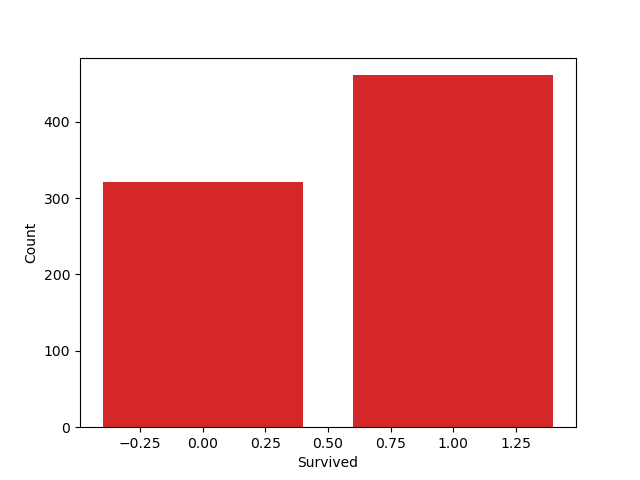

In [ ]:
%%python

titanic = spark.sql("select * from titanic")
titanic= titanic.toPandas()
plt.bar(titanic['Survived'].unique(), titanic['Survived'].value_counts())
plt.xlabel("Survived")
plt.ylabel("Count")
plt.savefig("sq.png")
Image(filename= "sq.png")


# Spliting :

In [ ]:
val dfs = titanic.randomSplit(Array(0.7, 0.3))
val trainDf = dfs(0).withColumnRenamed("Survived", "label")
val testDf = dfs(1)

trainDf.createOrReplaceTempView("trainDf")
testDf.createOrReplaceTempView("testDf")

dfs: Array[org.apache.spark.sql.Dataset[org.apache.spark.sql.Row]] = Array([Survived: int, Pclass: int ... 6 more fields], [Survived: int, Pclass: int ... 6 more fields])
trainDf: org.apache.spark.sql.DataFrame = [label: int, Pclass: int ... 6 more fields]
testDf: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [Survived: int, Pclass: int ... 6 more fields]


# Distinct valueurs des colonnes:

In [ ]:
titanic.select("Sex").distinct().show()
titanic.select("Pclass").distinct().show()
titanic.select("Embarked").distinct().show()

+------+
|   Sex|
+------+
|female|
|  male|
+------+

+------+
|Pclass|
+------+
|     1|
|     3|
|     2|
+------+

+--------+
|Embarked|
+--------+
|       Q|
|       C|
|       S|
+--------+



# OneHotEncoding :

In [ ]:
def handleCategorical(column: String): Array[PipelineStage] = {
  val stringIndexer = new StringIndexer().setInputCol(column)
    .setOutputCol(s"${column}_index")
    .setHandleInvalid("skip")
  val oneHot = new OneHotEncoder().setInputCol(s"${column}_index").setOutputCol(s"${column}_onehot")
  Array(stringIndexer, oneHot)
}

val genderStages = handleCategorical("Sex")
val embarkedStages = handleCategorical("Embarked")
val pClassStages = handleCategorical("Pclass")

handleCategorical: (column: String)Array[org.apache.spark.ml.PipelineStage]
genderStages: Array[org.apache.spark.ml.PipelineStage] = Array(strIdx_9b6bc572d9c9, oneHotEncoder_b466c96d5708)
embarkedStages: Array[org.apache.spark.ml.PipelineStage] = Array(strIdx_da61d4b0b755, oneHotEncoder_56d4f79e6f50)
pClassStages: Array[org.apache.spark.ml.PipelineStage] = Array(strIdx_6ee91580d2ae, oneHotEncoder_a1ec58afd25b)


# Vectors assembly:

In [ ]:
val cols = Array("Sex_onehot", "Embarked_onehot", "Pclass_onehot", "SibSp", "Parch", "Age", "Fare")
val vectorAssembler = new VectorAssembler().setInputCols(cols).setOutputCol("features")

cols: Array[String] = Array(Sex_onehot, Embarked_onehot, Pclass_onehot, SibSp, Parch, Age, Fare)
vectorAssembler: org.apache.spark.ml.feature.VectorAssembler = VectorAssembler: uid=vecAssembler_caa18903ea08, handleInvalid=error, numInputCols=7


# Fiting pipeline:

In [ ]:
val randomForestClassifier = new RandomForestClassifier()

val preProcessStages = genderStages ++ embarkedStages ++ pClassStages ++ Array(vectorAssembler)
val pipeline = new Pipeline().setStages(preProcessStages ++ Array(randomForestClassifier))

val model = pipeline.fit(trainDf)

randomForestClassifier: org.apache.spark.ml.classification.RandomForestClassifier = rfc_669617babf26
preProcessStages: Array[org.apache.spark.ml.PipelineStage] = Array(strIdx_9b6bc572d9c9, oneHotEncoder_b466c96d5708, strIdx_da61d4b0b755, oneHotEncoder_56d4f79e6f50, strIdx_6ee91580d2ae, oneHotEncoder_a1ec58afd25b, VectorAssembler: uid=vecAssembler_caa18903ea08, handleInvalid=error, numInputCols=7)
pipeline: org.apache.spark.ml.Pipeline = pipeline_56cf6da21c04
model: org.apache.spark.ml.PipelineModel = pipeline_56cf6da21c04


# Evaluation:

In [ ]:
def accuracyScore(df: DataFrame, label: String, predictCol: String) = {
  val rdd = df.select(label, predictCol).rdd.map(row ⇒ (row.getInt(0).toDouble, row.getDouble(1)))
  new MulticlassMetrics(rdd).accuracy}

println("test accuracy with pipeline " + accuracyScore(model.transform(testDf), "Survived", "prediction"))

test accuracy with pipeline 0.8


accuracyScore: (df: org.apache.spark.sql.DataFrame, label: String, predictCol: String)Double
